# Graph worlds

This environment demonstrates agents that can navigate a graph and find an object. Object is only visible when agent is at the same location as the object.

In [11]:
import jax.numpy as jnp
from jax import random as jr

key = jr.PRNGKey(0)

Start by generating a graph of locations

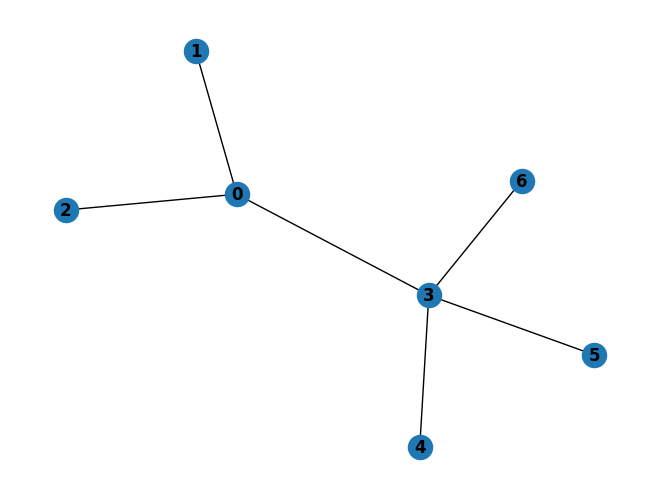

In [28]:
import networkx as nx
from pymdp.jax.envs import GraphEnv

def generate_connected_clusters(cluster_size=2, connections=2):
    edges = []
    connecting_node = 0
    while connecting_node < connections * cluster_size:
        edges += [(connecting_node, a) for a in range(connecting_node + 1, connecting_node + cluster_size + 1)]
        connecting_node = len(edges)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph, {
        "locations": [
            (f"hallway {i}" if len(list(graph.neighbors(loc))) > 1 else f"room {i}")
            for i, loc in enumerate(graph.nodes)
        ]
    }

graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
nx.draw(graph, with_labels=True, font_weight="bold")

Now we can create a GraphEnv given this graph. We specify two object locations and two agent locations. This will effectively create the environment with a batch size of 2.

In [21]:
env = GraphEnv(graph, object_locations=[3, 5], agent_locations=[0, 1])

To create an Agent, we reuse the environment's A and B tensors, but give the agent a uniform initial belief about the object location, and a preference to find (see) the object.

In [22]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

agent = Agent(A, B, C, D,None, None, None, A_dependencies=A_dependencies, B_dependencies=B_dependencies, policy_len=2)

Using the rollout function, we can easily simulate two agents in parallel for 10 timesteps...

In [23]:
from pymdp.jax.envs.rollout import rollout

last, result, env = rollout(agent, env, 10, key)

And plot their beliefs over time.

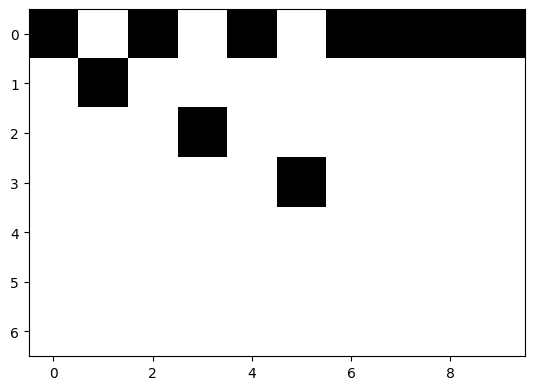

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(result["qs"][0][0, :, :].T, cmap="gray_r", vmin=0.0, vmax=1.0)


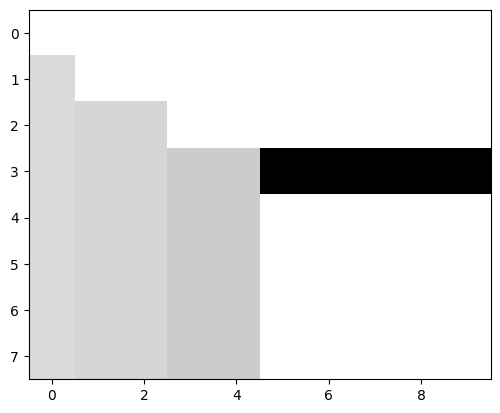

In [25]:
fig, ax = plt.subplots()
ax.imshow(result["qs"][1][0, :, :].T, cmap="gray_r", vmin=0.0, vmax=1.0)

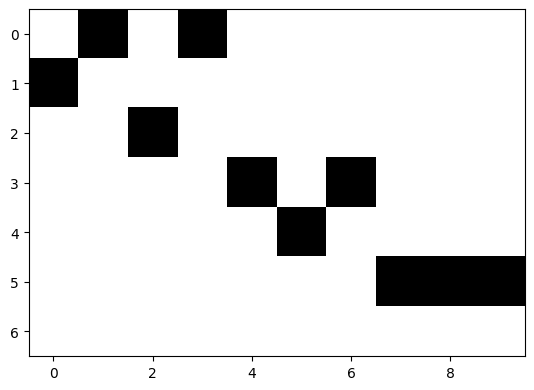

In [26]:
fig, ax = plt.subplots()
ax.imshow(result["qs"][0][1, :, :].T, cmap="gray_r", vmin=0.0, vmax=1.0)

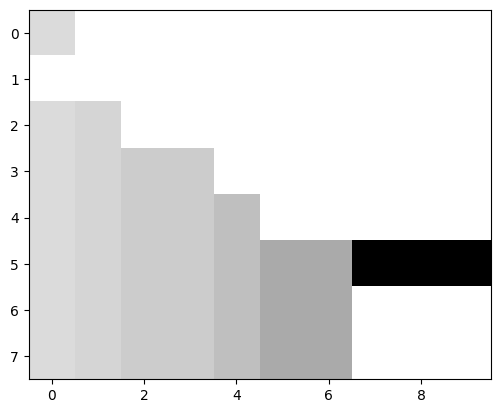

In [27]:
fig, ax = plt.subplots()
ax.imshow(result["qs"][1][1, :, :].T, cmap="gray_r", vmin=0.0, vmax=1.0)